In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import site
site.addsitedir('../../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
img1_dir = "../../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

gpu_device = 2

num_folds = 15

num_classes = 3

num_workers_tr = 8
batch_size_tr = 8
num_workers_vl = 8
batch_size_vl = 2

num_slices = 48
size_x = 320
size_y = 320

max_epochs = 500
net_channels=(32, 64, 64)
net_strides=(2, 2)

model_filename_base = "./results/BAMC_PTX_3DUNet-NS-Extruded.best_model.vfold"

num_images = len(all_images)
print(num_images)

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

62
53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.nii.gz
../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.extruded-overlay-NS.nii.gz


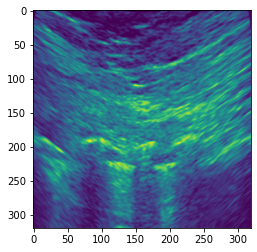

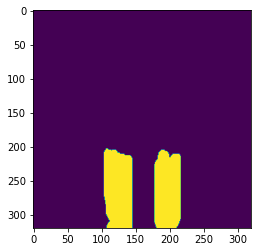

In [3]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[320,320,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keys=['image', 'label'],
            keep_size=True,
            mode=['trilinear', 'nearest']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[320,320,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            center_slice=30,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [5]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


torch.Size([2, 1, 320, 320, 48])
torch.Size([320, 320, 48])
image shape: torch.Size([320, 320, 48]), label shape: torch.Size([320, 320, 48])


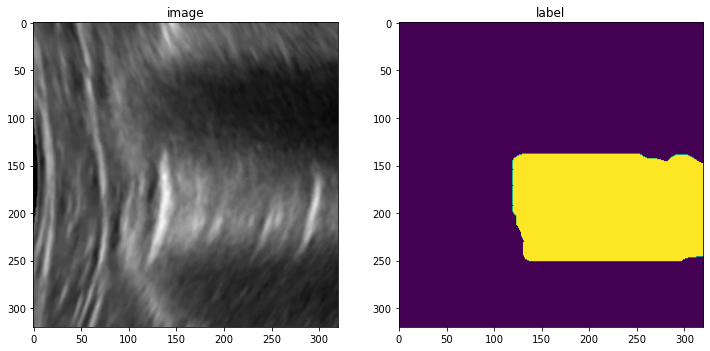

tensor(0.) tensor(1.)


In [6]:
imgnum = 1
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum][0], check_data["label"][imgnum][0])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 2])
plt.show()
print(label.min(), label.max())

In [7]:
device = torch.device("cuda:"+str(gpu_device))

In [8]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y, num_slices)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), model_filename_base+'_'+str(vfold_num)+'.pth')
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

In [ ]:
for i in range(6,num_folds,4):
    vfold_train(i, train_loader[i], val_loader[i])    

----------
6: epoch 1/500
1/1, train_loss: 0.7971
2/1, train_loss: 0.7777
3/1, train_loss: 0.7698
4/1, train_loss: 0.7629
5/1, train_loss: 0.7614
6/1, train_loss: 0.7386
7/1, train_loss: 0.7544
6 epoch 1 average loss: 0.7660
----------
6: epoch 2/500
1/1, train_loss: 0.7478
2/1, train_loss: 0.7643
3/1, train_loss: 0.7430
4/1, train_loss: 0.7385
5/1, train_loss: 0.7487
6/1, train_loss: 0.7363
7/1, train_loss: 0.7399
6 epoch 2 average loss: 0.7455
saved new best metric model
current epoch: 2 current mean dice: 0.1425
best mean dice: 0.1425 at epoch: 2
----------
6: epoch 3/500
1/1, train_loss: 0.7468
2/1, train_loss: 0.7550
3/1, train_loss: 0.7139
4/1, train_loss: 0.7480
5/1, train_loss: 0.7205
6/1, train_loss: 0.7181
7/1, train_loss: 0.7485
6 epoch 3 average loss: 0.7358
----------
6: epoch 4/500
1/1, train_loss: 0.7351
2/1, train_loss: 0.7144
3/1, train_loss: 0.7229
4/1, train_loss: 0.7303
5/1, train_loss: 0.7313
6/1, train_loss: 0.7095
7/1, train_loss: 0.7224
6 epoch 4 average loss: 0

1/1, train_loss: 0.5848
2/1, train_loss: 0.6252
3/1, train_loss: 0.5885
4/1, train_loss: 0.6281
5/1, train_loss: 0.6664
6/1, train_loss: 0.6087
7/1, train_loss: 0.5833
6 epoch 31 average loss: 0.6121
----------
6: epoch 32/500
1/1, train_loss: 0.5880
2/1, train_loss: 0.6147
3/1, train_loss: 0.6558
4/1, train_loss: 0.5982
5/1, train_loss: 0.6084
6/1, train_loss: 0.5922
7/1, train_loss: 0.6054
6 epoch 32 average loss: 0.6090
saved new best metric model
current epoch: 32 current mean dice: 0.4696
best mean dice: 0.4696 at epoch: 32
----------
6: epoch 33/500
1/1, train_loss: 0.6050
2/1, train_loss: 0.6250
3/1, train_loss: 0.5937
4/1, train_loss: 0.5989
5/1, train_loss: 0.5865
6/1, train_loss: 0.6006
7/1, train_loss: 0.6458
6 epoch 33 average loss: 0.6079
----------
6: epoch 34/500
1/1, train_loss: 0.6148
2/1, train_loss: 0.5824
3/1, train_loss: 0.5657
4/1, train_loss: 0.6327
5/1, train_loss: 0.6020
6/1, train_loss: 0.6091
7/1, train_loss: 0.6236
6 epoch 34 average loss: 0.6043
saved new b

6/1, train_loss: 0.5519
7/1, train_loss: 0.5477
6 epoch 61 average loss: 0.5539
----------
6: epoch 62/500
1/1, train_loss: 0.6045
2/1, train_loss: 0.5395
3/1, train_loss: 0.5864
4/1, train_loss: 0.5050
5/1, train_loss: 0.5378
6/1, train_loss: 0.5588
7/1, train_loss: 0.5326
6 epoch 62 average loss: 0.5521
current epoch: 62 current mean dice: 0.4719
best mean dice: 0.4814 at epoch: 36
----------
6: epoch 63/500
1/1, train_loss: 0.6039
2/1, train_loss: 0.5553
3/1, train_loss: 0.5764
4/1, train_loss: 0.5494
5/1, train_loss: 0.5302
6/1, train_loss: 0.5704
7/1, train_loss: 0.5241
6 epoch 63 average loss: 0.5585
----------
6: epoch 64/500
1/1, train_loss: 0.5706
2/1, train_loss: 0.5418
3/1, train_loss: 0.5276
4/1, train_loss: 0.5967
5/1, train_loss: 0.5732
6/1, train_loss: 0.5526
7/1, train_loss: 0.5131
6 epoch 64 average loss: 0.5537
current epoch: 64 current mean dice: 0.4533
best mean dice: 0.4814 at epoch: 36
----------
6: epoch 65/500
1/1, train_loss: 0.5638
2/1, train_loss: 0.5479
3/1,

2/1, train_loss: 0.5055
3/1, train_loss: 0.5288
4/1, train_loss: 0.4934
5/1, train_loss: 0.5389
6/1, train_loss: 0.5192
7/1, train_loss: 0.5221
6 epoch 92 average loss: 0.5139
current epoch: 92 current mean dice: 0.4060
best mean dice: 0.5340 at epoch: 68
----------
6: epoch 93/500
1/1, train_loss: 0.5097
2/1, train_loss: 0.5545
3/1, train_loss: 0.5142
4/1, train_loss: 0.4958
5/1, train_loss: 0.5036
6/1, train_loss: 0.5463
7/1, train_loss: 0.4994
6 epoch 93 average loss: 0.5176
----------
6: epoch 94/500
1/1, train_loss: 0.5044
2/1, train_loss: 0.5114
3/1, train_loss: 0.4924
4/1, train_loss: 0.5269
5/1, train_loss: 0.5308
6/1, train_loss: 0.5146
7/1, train_loss: 0.4949
6 epoch 94 average loss: 0.5108
current epoch: 94 current mean dice: 0.4501
best mean dice: 0.5340 at epoch: 68
----------
6: epoch 95/500
1/1, train_loss: 0.4883
2/1, train_loss: 0.4995
3/1, train_loss: 0.4971
4/1, train_loss: 0.5019
5/1, train_loss: 0.5546
6/1, train_loss: 0.4993
7/1, train_loss: 0.5109
6 epoch 95 aver

6/1, train_loss: 0.4882
7/1, train_loss: 0.4720
6 epoch 122 average loss: 0.4889
current epoch: 122 current mean dice: 0.3271
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 123/500
1/1, train_loss: 0.5136
2/1, train_loss: 0.4712
3/1, train_loss: 0.4950
4/1, train_loss: 0.4798
5/1, train_loss: 0.4824
6/1, train_loss: 0.4606
7/1, train_loss: 0.5021
6 epoch 123 average loss: 0.4864
----------
6: epoch 124/500
1/1, train_loss: 0.5133
2/1, train_loss: 0.4637
3/1, train_loss: 0.4748
4/1, train_loss: 0.4901
5/1, train_loss: 0.4720
6/1, train_loss: 0.4579
7/1, train_loss: 0.4924
6 epoch 124 average loss: 0.4806
current epoch: 124 current mean dice: 0.1777
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 125/500
1/1, train_loss: 0.4594
2/1, train_loss: 0.4856
3/1, train_loss: 0.4887
4/1, train_loss: 0.4991
5/1, train_loss: 0.5190
6/1, train_loss: 0.4902
7/1, train_loss: 0.4533
6 epoch 125 average loss: 0.4851
----------
6: epoch 126/500
1/1, train_loss: 0.5157
2/1, train_loss:

1/1, train_loss: 0.4602
2/1, train_loss: 0.4637
3/1, train_loss: 0.4498
4/1, train_loss: 0.4602
5/1, train_loss: 0.4995
6/1, train_loss: 0.4687
7/1, train_loss: 0.4745
6 epoch 153 average loss: 0.4681
----------
6: epoch 154/500
1/1, train_loss: 0.4651
2/1, train_loss: 0.4683
3/1, train_loss: 0.4569
4/1, train_loss: 0.4746
5/1, train_loss: 0.4701
6/1, train_loss: 0.4694
7/1, train_loss: 0.4653
6 epoch 154 average loss: 0.4671
current epoch: 154 current mean dice: 0.1653
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 155/500
1/1, train_loss: 0.4968
2/1, train_loss: 0.4471
3/1, train_loss: 0.4783
4/1, train_loss: 0.4484
5/1, train_loss: 0.4597
6/1, train_loss: 0.5178
7/1, train_loss: 0.4836
6 epoch 155 average loss: 0.4759
----------
6: epoch 156/500
1/1, train_loss: 0.4516
2/1, train_loss: 0.4896
3/1, train_loss: 0.4939
4/1, train_loss: 0.4937
5/1, train_loss: 0.4530
6/1, train_loss: 0.4814
7/1, train_loss: 0.4574
6 epoch 156 average loss: 0.4744
current epoch: 156 current mea

5/1, train_loss: 0.4564
6/1, train_loss: 0.4665
7/1, train_loss: 0.4641
6 epoch 183 average loss: 0.4583
----------
6: epoch 184/500
1/1, train_loss: 0.4502
2/1, train_loss: 0.4461
3/1, train_loss: 0.4376
4/1, train_loss: 0.4651
5/1, train_loss: 0.4551
6/1, train_loss: 0.4970
7/1, train_loss: 0.4408
6 epoch 184 average loss: 0.4560
current epoch: 184 current mean dice: 0.0684
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 185/500
1/1, train_loss: 0.4523
2/1, train_loss: 0.4415
3/1, train_loss: 0.4263
4/1, train_loss: 0.4835
5/1, train_loss: 0.4497
6/1, train_loss: 0.5093
7/1, train_loss: 0.4544
6 epoch 185 average loss: 0.4596
----------
6: epoch 186/500
1/1, train_loss: 0.4689
2/1, train_loss: 0.4582
3/1, train_loss: 0.4607
4/1, train_loss: 0.4488
5/1, train_loss: 0.4726
6/1, train_loss: 0.4658
7/1, train_loss: 0.4398
6 epoch 186 average loss: 0.4593
current epoch: 186 current mean dice: 0.3689
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 187/500
1/1, train_loss:

1/1, train_loss: 0.4507
2/1, train_loss: 0.4339
3/1, train_loss: 0.4752
4/1, train_loss: 0.4355
5/1, train_loss: 0.4461
6/1, train_loss: 0.4465
7/1, train_loss: 0.4339
6 epoch 214 average loss: 0.4460
current epoch: 214 current mean dice: 0.2335
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 215/500
1/1, train_loss: 0.4550
2/1, train_loss: 0.4299
3/1, train_loss: 0.4410
4/1, train_loss: 0.4679
5/1, train_loss: 0.4375
6/1, train_loss: 0.4460
7/1, train_loss: 0.4455
6 epoch 215 average loss: 0.4461
----------
6: epoch 216/500
1/1, train_loss: 0.4637
2/1, train_loss: 0.4736
3/1, train_loss: 0.4439
4/1, train_loss: 0.4726
5/1, train_loss: 0.4680
6/1, train_loss: 0.4337
7/1, train_loss: 0.4123
6 epoch 216 average loss: 0.4525
current epoch: 216 current mean dice: 0.2349
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 217/500
1/1, train_loss: 0.4603
2/1, train_loss: 0.4474
3/1, train_loss: 0.4365
4/1, train_loss: 0.4395
5/1, train_loss: 0.4430
6/1, train_loss: 0.4369
7/1, 

5/1, train_loss: 0.4272
6/1, train_loss: 0.4366
7/1, train_loss: 0.4896
6 epoch 244 average loss: 0.4527
current epoch: 244 current mean dice: 0.2909
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 245/500
1/1, train_loss: 0.4276
2/1, train_loss: 0.4428
3/1, train_loss: 0.4485
4/1, train_loss: 0.4629
5/1, train_loss: 0.4470
6/1, train_loss: 0.4534
7/1, train_loss: 0.4228
6 epoch 245 average loss: 0.4436
----------
6: epoch 246/500
1/1, train_loss: 0.4285
2/1, train_loss: 0.4300
3/1, train_loss: 0.4919
4/1, train_loss: 0.4493
5/1, train_loss: 0.4747
6/1, train_loss: 0.4453
7/1, train_loss: 0.4912
6 epoch 246 average loss: 0.4587
current epoch: 246 current mean dice: 0.2366
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 247/500
1/1, train_loss: 0.4568
2/1, train_loss: 0.4507
3/1, train_loss: 0.4464
4/1, train_loss: 0.4594
5/1, train_loss: 0.4667
6/1, train_loss: 0.4083
7/1, train_loss: 0.4504
6 epoch 247 average loss: 0.4484
----------
6: epoch 248/500
1/1, train_loss:

current epoch: 274 current mean dice: 0.1364
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 275/500
1/1, train_loss: 0.4329
2/1, train_loss: 0.4342
3/1, train_loss: 0.4462
4/1, train_loss: 0.4361
5/1, train_loss: 0.4498
6/1, train_loss: 0.4147
7/1, train_loss: 0.4370
6 epoch 275 average loss: 0.4358
----------
6: epoch 276/500
1/1, train_loss: 0.4422
2/1, train_loss: 0.4525
3/1, train_loss: 0.4307
4/1, train_loss: 0.4203
5/1, train_loss: 0.4150
6/1, train_loss: 0.4696
7/1, train_loss: 0.4409
6 epoch 276 average loss: 0.4387
current epoch: 276 current mean dice: 0.2681
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 277/500
1/1, train_loss: 0.4146
2/1, train_loss: 0.4349
3/1, train_loss: 0.4407
4/1, train_loss: 0.4343
5/1, train_loss: 0.4605
6/1, train_loss: 0.4342
7/1, train_loss: 0.4386
6 epoch 277 average loss: 0.4368
----------
6: epoch 278/500
1/1, train_loss: 0.4546
2/1, train_loss: 0.4474
3/1, train_loss: 0.4426
4/1, train_loss: 0.4242
5/1, train_loss: 0.4267
6

1/1, train_loss: 0.4405
2/1, train_loss: 0.4410
3/1, train_loss: 0.4562
4/1, train_loss: 0.4304
5/1, train_loss: 0.4308
6/1, train_loss: 0.4386
7/1, train_loss: 0.4400
6 epoch 305 average loss: 0.4397
----------
6: epoch 306/500
1/1, train_loss: 0.4318
2/1, train_loss: 0.4238
3/1, train_loss: 0.4575
4/1, train_loss: 0.4426
5/1, train_loss: 0.4253
6/1, train_loss: 0.4395
7/1, train_loss: 0.4096
6 epoch 306 average loss: 0.4329
current epoch: 306 current mean dice: 0.2301
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 307/500
1/1, train_loss: 0.4477
2/1, train_loss: 0.4175
3/1, train_loss: 0.4415
4/1, train_loss: 0.4183
5/1, train_loss: 0.4379
6/1, train_loss: 0.4377
7/1, train_loss: 0.4206
6 epoch 307 average loss: 0.4316
----------
6: epoch 308/500
1/1, train_loss: 0.4223
2/1, train_loss: 0.4317
3/1, train_loss: 0.4138
4/1, train_loss: 0.4176
5/1, train_loss: 0.4696
6/1, train_loss: 0.4306
7/1, train_loss: 0.4120
6 epoch 308 average loss: 0.4282
current epoch: 308 current mea

5/1, train_loss: 0.4469
6/1, train_loss: 0.4302
7/1, train_loss: 0.4137
6 epoch 335 average loss: 0.4277
----------
6: epoch 336/500
1/1, train_loss: 0.4358
2/1, train_loss: 0.4332
3/1, train_loss: 0.4288
4/1, train_loss: 0.4026
5/1, train_loss: 0.4192
6/1, train_loss: 0.4690
7/1, train_loss: 0.4198
6 epoch 336 average loss: 0.4298
current epoch: 336 current mean dice: 0.2353
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 337/500
1/1, train_loss: 0.4211
2/1, train_loss: 0.4631
3/1, train_loss: 0.4101
4/1, train_loss: 0.4090
5/1, train_loss: 0.4291
6/1, train_loss: 0.4924
7/1, train_loss: 0.4503
6 epoch 337 average loss: 0.4393
----------
6: epoch 338/500
1/1, train_loss: 0.4316
2/1, train_loss: 0.4562
3/1, train_loss: 0.4190
4/1, train_loss: 0.4362
5/1, train_loss: 0.4380
6/1, train_loss: 0.4218
7/1, train_loss: 0.4322
6 epoch 338 average loss: 0.4336
current epoch: 338 current mean dice: 0.3106
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 339/500
1/1, train_loss:

1/1, train_loss: 0.4201
2/1, train_loss: 0.4314
3/1, train_loss: 0.4201
4/1, train_loss: 0.4261
5/1, train_loss: 0.4240
6/1, train_loss: 0.4094
7/1, train_loss: 0.4258
6 epoch 366 average loss: 0.4224
current epoch: 366 current mean dice: 0.1994
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 367/500
1/1, train_loss: 0.4116
2/1, train_loss: 0.4146
3/1, train_loss: 0.4268
4/1, train_loss: 0.3994
5/1, train_loss: 0.4095
6/1, train_loss: 0.4616
7/1, train_loss: 0.4444
6 epoch 367 average loss: 0.4240
----------
6: epoch 368/500
1/1, train_loss: 0.4027
2/1, train_loss: 0.4241
3/1, train_loss: 0.4239
4/1, train_loss: 0.4273
5/1, train_loss: 0.4171
6/1, train_loss: 0.4239
7/1, train_loss: 0.4214
6 epoch 368 average loss: 0.4201
current epoch: 368 current mean dice: 0.2818
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 369/500
1/1, train_loss: 0.4245
2/1, train_loss: 0.4092
3/1, train_loss: 0.4189
4/1, train_loss: 0.4479
5/1, train_loss: 0.4004
6/1, train_loss: 0.4347
7/1, 

5/1, train_loss: 0.4035
6/1, train_loss: 0.4435
7/1, train_loss: 0.4251
6 epoch 396 average loss: 0.4262
current epoch: 396 current mean dice: 0.2520
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 397/500
1/1, train_loss: 0.4086
2/1, train_loss: 0.4146
3/1, train_loss: 0.4376
4/1, train_loss: 0.4433
5/1, train_loss: 0.4358
6/1, train_loss: 0.3961
7/1, train_loss: 0.4416
6 epoch 397 average loss: 0.4254
----------
6: epoch 398/500
1/1, train_loss: 0.4172
2/1, train_loss: 0.4163
3/1, train_loss: 0.4203
4/1, train_loss: 0.4338
5/1, train_loss: 0.4476
6/1, train_loss: 0.4260
7/1, train_loss: 0.4068
6 epoch 398 average loss: 0.4240
current epoch: 398 current mean dice: 0.2351
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 399/500
1/1, train_loss: 0.4266
2/1, train_loss: 0.4360
3/1, train_loss: 0.4569
4/1, train_loss: 0.4035
5/1, train_loss: 0.3983
6/1, train_loss: 0.4507
7/1, train_loss: 0.4396
6 epoch 399 average loss: 0.4302
----------
6: epoch 400/500
1/1, train_loss:

current epoch: 426 current mean dice: 0.3195
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 427/500
1/1, train_loss: 0.4088
2/1, train_loss: 0.4185
3/1, train_loss: 0.3979
4/1, train_loss: 0.4340
5/1, train_loss: 0.4220
6/1, train_loss: 0.4202
7/1, train_loss: 0.4336
6 epoch 427 average loss: 0.4193
----------
6: epoch 428/500
1/1, train_loss: 0.4332
2/1, train_loss: 0.3997
3/1, train_loss: 0.4107
4/1, train_loss: 0.4149
5/1, train_loss: 0.4050
6/1, train_loss: 0.4402
7/1, train_loss: 0.4170
6 epoch 428 average loss: 0.4172
current epoch: 428 current mean dice: 0.2950
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 429/500
1/1, train_loss: 0.4145
2/1, train_loss: 0.4101
3/1, train_loss: 0.4013
4/1, train_loss: 0.4302
5/1, train_loss: 0.4203
6/1, train_loss: 0.4076
7/1, train_loss: 0.4182
6 epoch 429 average loss: 0.4146
----------
6: epoch 430/500
1/1, train_loss: 0.4146
2/1, train_loss: 0.4128
3/1, train_loss: 0.4340
4/1, train_loss: 0.4165
5/1, train_loss: 0.3945
6

1/1, train_loss: 0.4087
2/1, train_loss: 0.4216
3/1, train_loss: 0.4040
4/1, train_loss: 0.4300
5/1, train_loss: 0.4110
6/1, train_loss: 0.4097
7/1, train_loss: 0.4453
6 epoch 457 average loss: 0.4186
----------
6: epoch 458/500
1/1, train_loss: 0.4124
2/1, train_loss: 0.4161
3/1, train_loss: 0.4120
4/1, train_loss: 0.4045
5/1, train_loss: 0.3975
6/1, train_loss: 0.4104
7/1, train_loss: 0.4384
6 epoch 458 average loss: 0.4130
current epoch: 458 current mean dice: 0.2865
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 459/500
1/1, train_loss: 0.3904
2/1, train_loss: 0.4276
3/1, train_loss: 0.4257
4/1, train_loss: 0.4129
5/1, train_loss: 0.4057
6/1, train_loss: 0.4234
7/1, train_loss: 0.4021
6 epoch 459 average loss: 0.4126
----------
6: epoch 460/500
1/1, train_loss: 0.4088
2/1, train_loss: 0.3902
3/1, train_loss: 0.3899
4/1, train_loss: 0.4215
5/1, train_loss: 0.4209
6/1, train_loss: 0.4234
7/1, train_loss: 0.4652
6 epoch 460 average loss: 0.4171
current epoch: 460 current mea

5/1, train_loss: 0.4293
6/1, train_loss: 0.4240
7/1, train_loss: 0.4126
6 epoch 487 average loss: 0.4157
----------
6: epoch 488/500
1/1, train_loss: 0.4108
2/1, train_loss: 0.3984
3/1, train_loss: 0.4176
4/1, train_loss: 0.4096
5/1, train_loss: 0.4115
6/1, train_loss: 0.4063
7/1, train_loss: 0.4237
6 epoch 488 average loss: 0.4112
current epoch: 488 current mean dice: 0.1712
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 489/500
1/1, train_loss: 0.4084
2/1, train_loss: 0.4235
3/1, train_loss: 0.3978
4/1, train_loss: 0.4092
5/1, train_loss: 0.4127
6/1, train_loss: 0.4007
7/1, train_loss: 0.4407
6 epoch 489 average loss: 0.4133
----------
6: epoch 490/500
1/1, train_loss: 0.4136
2/1, train_loss: 0.4333
3/1, train_loss: 0.4094
4/1, train_loss: 0.3901
5/1, train_loss: 0.4144
6/1, train_loss: 0.3951
7/1, train_loss: 0.4413
6 epoch 490 average loss: 0.4139
current epoch: 490 current mean dice: 0.3285
best mean dice: 0.5631 at epoch: 100
----------
6: epoch 491/500
1/1, train_loss:

6/1, train_loss: 0.7112
7/1, train_loss: 0.6949
10 epoch 17 average loss: 0.7015
----------
10: epoch 18/500
1/1, train_loss: 0.6819
2/1, train_loss: 0.7022
3/1, train_loss: 0.7094
4/1, train_loss: 0.7281
5/1, train_loss: 0.7044
6/1, train_loss: 0.6925
7/1, train_loss: 0.6781
10 epoch 18 average loss: 0.6995
current epoch: 18 current mean dice: 0.3408
best mean dice: 0.3529 at epoch: 16
----------
10: epoch 19/500
1/1, train_loss: 0.6762
2/1, train_loss: 0.6821
3/1, train_loss: 0.7031
4/1, train_loss: 0.7213
5/1, train_loss: 0.6906
6/1, train_loss: 0.7046
7/1, train_loss: 0.6778
10 epoch 19 average loss: 0.6936
----------
10: epoch 20/500
1/1, train_loss: 0.6835
2/1, train_loss: 0.6752
3/1, train_loss: 0.7087
4/1, train_loss: 0.6961
5/1, train_loss: 0.6861
6/1, train_loss: 0.6922
7/1, train_loss: 0.6678
10 epoch 20 average loss: 0.6871
saved new best metric model
current epoch: 20 current mean dice: 0.4323
best mean dice: 0.4323 at epoch: 20
----------
10: epoch 21/500
1/1, train_loss:

5/1, train_loss: 0.5831
6/1, train_loss: 0.6031
7/1, train_loss: 0.6024
10 epoch 47 average loss: 0.5870
----------
10: epoch 48/500
1/1, train_loss: 0.6247
2/1, train_loss: 0.5813
3/1, train_loss: 0.5871
4/1, train_loss: 0.6126
5/1, train_loss: 0.5792
6/1, train_loss: 0.5803
7/1, train_loss: 0.5603
10 epoch 48 average loss: 0.5894
current epoch: 48 current mean dice: 0.4918
best mean dice: 0.6863 at epoch: 36
----------
10: epoch 49/500
1/1, train_loss: 0.5472
2/1, train_loss: 0.5925
3/1, train_loss: 0.5728
4/1, train_loss: 0.6022
5/1, train_loss: 0.5514
6/1, train_loss: 0.6163
7/1, train_loss: 0.5869
10 epoch 49 average loss: 0.5813
----------
10: epoch 50/500
1/1, train_loss: 0.5935
2/1, train_loss: 0.5613
3/1, train_loss: 0.5675
4/1, train_loss: 0.5662
5/1, train_loss: 0.5651
6/1, train_loss: 0.6364
7/1, train_loss: 0.5652
10 epoch 50 average loss: 0.5793
current epoch: 50 current mean dice: 0.6163
best mean dice: 0.6863 at epoch: 36
----------
10: epoch 51/500
1/1, train_loss: 0.5

1/1, train_loss: 0.5017
2/1, train_loss: 0.5199
3/1, train_loss: 0.5403
4/1, train_loss: 0.5250
5/1, train_loss: 0.5728
6/1, train_loss: 0.5239
7/1, train_loss: 0.5090
10 epoch 78 average loss: 0.5275
current epoch: 78 current mean dice: 0.6330
best mean dice: 0.7364 at epoch: 56
----------
10: epoch 79/500
1/1, train_loss: 0.5254
2/1, train_loss: 0.5283
3/1, train_loss: 0.5207
4/1, train_loss: 0.5418
5/1, train_loss: 0.5605
6/1, train_loss: 0.5403
7/1, train_loss: 0.5053
10 epoch 79 average loss: 0.5318
----------
10: epoch 80/500
1/1, train_loss: 0.5065
2/1, train_loss: 0.5240
3/1, train_loss: 0.5325
4/1, train_loss: 0.5561
5/1, train_loss: 0.5294
6/1, train_loss: 0.5240
7/1, train_loss: 0.4964
10 epoch 80 average loss: 0.5241
current epoch: 80 current mean dice: 0.7137
best mean dice: 0.7364 at epoch: 56
----------
10: epoch 81/500
1/1, train_loss: 0.5196
2/1, train_loss: 0.5169
3/1, train_loss: 0.5515
4/1, train_loss: 0.5456
5/1, train_loss: 0.5148
6/1, train_loss: 0.5382
7/1, trai

3/1, train_loss: 0.4796
4/1, train_loss: 0.4784
5/1, train_loss: 0.5165
6/1, train_loss: 0.5090
7/1, train_loss: 0.5323
10 epoch 108 average loss: 0.4992
current epoch: 108 current mean dice: 0.7129
best mean dice: 0.7507 at epoch: 106
----------
10: epoch 109/500
1/1, train_loss: 0.5071
2/1, train_loss: 0.5021
3/1, train_loss: 0.5146
4/1, train_loss: 0.4719
5/1, train_loss: 0.5107
6/1, train_loss: 0.5006
7/1, train_loss: 0.4867
10 epoch 109 average loss: 0.4991
----------
10: epoch 110/500
1/1, train_loss: 0.4940
2/1, train_loss: 0.4826
3/1, train_loss: 0.4980
4/1, train_loss: 0.5411
5/1, train_loss: 0.4839
6/1, train_loss: 0.4917
7/1, train_loss: 0.4800
10 epoch 110 average loss: 0.4959
current epoch: 110 current mean dice: 0.6248
best mean dice: 0.7507 at epoch: 106
----------
10: epoch 111/500
1/1, train_loss: 0.4897
2/1, train_loss: 0.4915
3/1, train_loss: 0.4961
4/1, train_loss: 0.4803
5/1, train_loss: 0.5463
6/1, train_loss: 0.4910
7/1, train_loss: 0.5070
10 epoch 111 average lo

4/1, train_loss: 0.4737
5/1, train_loss: 0.4785
6/1, train_loss: 0.4901
7/1, train_loss: 0.4804
10 epoch 138 average loss: 0.4780
current epoch: 138 current mean dice: 0.5067
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 139/500
1/1, train_loss: 0.4688
2/1, train_loss: 0.4787
3/1, train_loss: 0.4874
4/1, train_loss: 0.4587
5/1, train_loss: 0.4869
6/1, train_loss: 0.4870
7/1, train_loss: 0.4588
10 epoch 139 average loss: 0.4752
----------
10: epoch 140/500
1/1, train_loss: 0.4700
2/1, train_loss: 0.4916
3/1, train_loss: 0.5118
4/1, train_loss: 0.4920
5/1, train_loss: 0.4933
6/1, train_loss: 0.4731
7/1, train_loss: 0.4581
10 epoch 140 average loss: 0.4843
current epoch: 140 current mean dice: 0.7258
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 141/500
1/1, train_loss: 0.4903
2/1, train_loss: 0.5114
3/1, train_loss: 0.4714
4/1, train_loss: 0.4633
5/1, train_loss: 0.4638
6/1, train_loss: 0.4747
7/1, train_loss: 0.4605
10 epoch 141 average loss: 0.4765
----------
10

6/1, train_loss: 0.4575
7/1, train_loss: 0.4669
10 epoch 168 average loss: 0.4734
current epoch: 168 current mean dice: 0.6779
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 169/500
1/1, train_loss: 0.4437
2/1, train_loss: 0.4739
3/1, train_loss: 0.4767
4/1, train_loss: 0.4568
5/1, train_loss: 0.4996
6/1, train_loss: 0.4622
7/1, train_loss: 0.4404
10 epoch 169 average loss: 0.4648
----------
10: epoch 170/500
1/1, train_loss: 0.4864
2/1, train_loss: 0.4679
3/1, train_loss: 0.4518
4/1, train_loss: 0.4682
5/1, train_loss: 0.4817
6/1, train_loss: 0.4803
7/1, train_loss: 0.4365
10 epoch 170 average loss: 0.4675
current epoch: 170 current mean dice: 0.6649
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 171/500
1/1, train_loss: 0.4863
2/1, train_loss: 0.4309
3/1, train_loss: 0.4663
4/1, train_loss: 0.4569
5/1, train_loss: 0.4716
6/1, train_loss: 0.4940
7/1, train_loss: 0.4571
10 epoch 171 average loss: 0.4662
----------
10: epoch 172/500
1/1, train_loss: 0.4751
2/1, tra

10 epoch 198 average loss: 0.4631
current epoch: 198 current mean dice: 0.5241
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 199/500
1/1, train_loss: 0.4806
2/1, train_loss: 0.4497
3/1, train_loss: 0.4386
4/1, train_loss: 0.4539
5/1, train_loss: 0.4729
6/1, train_loss: 0.4650
7/1, train_loss: 0.4944
10 epoch 199 average loss: 0.4650
----------
10: epoch 200/500
1/1, train_loss: 0.4695
2/1, train_loss: 0.4606
3/1, train_loss: 0.4297
4/1, train_loss: 0.5012
5/1, train_loss: 0.4636
6/1, train_loss: 0.4525
7/1, train_loss: 0.4714
10 epoch 200 average loss: 0.4641
current epoch: 200 current mean dice: 0.5647
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 201/500
1/1, train_loss: 0.4569
2/1, train_loss: 0.4857
3/1, train_loss: 0.4677
4/1, train_loss: 0.4328
5/1, train_loss: 0.4564
6/1, train_loss: 0.4603
7/1, train_loss: 0.4433
10 epoch 201 average loss: 0.4576
----------
10: epoch 202/500
1/1, train_loss: 0.4248
2/1, train_loss: 0.4748
3/1, train_loss: 0.4539
4/1, tra

current epoch: 228 current mean dice: 0.5899
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 229/500
1/1, train_loss: 0.4255
2/1, train_loss: 0.4519
3/1, train_loss: 0.4568
4/1, train_loss: 0.4585
5/1, train_loss: 0.4562
6/1, train_loss: 0.4270
7/1, train_loss: 0.4803
10 epoch 229 average loss: 0.4509
----------
10: epoch 230/500
1/1, train_loss: 0.4548
2/1, train_loss: 0.4568
3/1, train_loss: 0.4344
4/1, train_loss: 0.4396
5/1, train_loss: 0.5044
6/1, train_loss: 0.4345
7/1, train_loss: 0.4350
10 epoch 230 average loss: 0.4514
current epoch: 230 current mean dice: 0.7325
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 231/500
1/1, train_loss: 0.4880
2/1, train_loss: 0.4700
3/1, train_loss: 0.4728
4/1, train_loss: 0.4463
5/1, train_loss: 0.4674
6/1, train_loss: 0.4589
7/1, train_loss: 0.4258
10 epoch 231 average loss: 0.4613
----------
10: epoch 232/500
1/1, train_loss: 0.4363
2/1, train_loss: 0.4586
3/1, train_loss: 0.4368
4/1, train_loss: 0.4266
5/1, train_loss: 0

1/1, train_loss: 0.4519
2/1, train_loss: 0.4417
3/1, train_loss: 0.4525
4/1, train_loss: 0.4202
5/1, train_loss: 0.4352
6/1, train_loss: 0.4748
7/1, train_loss: 0.4306
10 epoch 259 average loss: 0.4438
----------
10: epoch 260/500
1/1, train_loss: 0.4434
2/1, train_loss: 0.4607
3/1, train_loss: 0.4419
4/1, train_loss: 0.4336
5/1, train_loss: 0.4489
6/1, train_loss: 0.4272
7/1, train_loss: 0.4659
10 epoch 260 average loss: 0.4459
current epoch: 260 current mean dice: 0.7291
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 261/500
1/1, train_loss: 0.4490
2/1, train_loss: 0.4288
3/1, train_loss: 0.4815
4/1, train_loss: 0.4387
5/1, train_loss: 0.4596
6/1, train_loss: 0.4548
7/1, train_loss: 0.4386
10 epoch 261 average loss: 0.4502
----------
10: epoch 262/500
1/1, train_loss: 0.4397
2/1, train_loss: 0.4682
3/1, train_loss: 0.4432
4/1, train_loss: 0.4459
5/1, train_loss: 0.4529
6/1, train_loss: 0.4766
7/1, train_loss: 0.4793
10 epoch 262 average loss: 0.4580
current epoch: 262 curr

3/1, train_loss: 0.4369
4/1, train_loss: 0.4228
5/1, train_loss: 0.4371
6/1, train_loss: 0.4465
7/1, train_loss: 0.4421
10 epoch 289 average loss: 0.4389
----------
10: epoch 290/500
1/1, train_loss: 0.4421
2/1, train_loss: 0.4462
3/1, train_loss: 0.4423
4/1, train_loss: 0.4205
5/1, train_loss: 0.4386
6/1, train_loss: 0.4303
7/1, train_loss: 0.4979
10 epoch 290 average loss: 0.4454
current epoch: 290 current mean dice: 0.5206
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 291/500
1/1, train_loss: 0.4553
2/1, train_loss: 0.4576
3/1, train_loss: 0.4231
4/1, train_loss: 0.4479
5/1, train_loss: 0.4142
6/1, train_loss: 0.4429
7/1, train_loss: 0.4372
10 epoch 291 average loss: 0.4397
----------
10: epoch 292/500
1/1, train_loss: 0.4450
2/1, train_loss: 0.4190
3/1, train_loss: 0.4546
4/1, train_loss: 0.4315
5/1, train_loss: 0.4132
6/1, train_loss: 0.4202
7/1, train_loss: 0.4815
10 epoch 292 average loss: 0.4378
current epoch: 292 current mean dice: 0.7277
best mean dice: 0.7650 at 

5/1, train_loss: 0.4243
6/1, train_loss: 0.4491
7/1, train_loss: 0.4528
10 epoch 319 average loss: 0.4396
----------
10: epoch 320/500
1/1, train_loss: 0.4479
2/1, train_loss: 0.4373
3/1, train_loss: 0.4382
4/1, train_loss: 0.4284
5/1, train_loss: 0.4199
6/1, train_loss: 0.4514
7/1, train_loss: 0.4207
10 epoch 320 average loss: 0.4348
current epoch: 320 current mean dice: 0.7306
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 321/500
1/1, train_loss: 0.4163
2/1, train_loss: 0.4353
3/1, train_loss: 0.4316
4/1, train_loss: 0.4263
5/1, train_loss: 0.4180
6/1, train_loss: 0.4262
7/1, train_loss: 0.4600
10 epoch 321 average loss: 0.4305
----------
10: epoch 322/500
1/1, train_loss: 0.4818
2/1, train_loss: 0.4264
3/1, train_loss: 0.4085
4/1, train_loss: 0.4168
5/1, train_loss: 0.4326
6/1, train_loss: 0.4397
7/1, train_loss: 0.4223
10 epoch 322 average loss: 0.4326
current epoch: 322 current mean dice: 0.6289
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 323/500
1/1, tra

7/1, train_loss: 0.4546
10 epoch 349 average loss: 0.4335
----------
10: epoch 350/500
1/1, train_loss: 0.4345
2/1, train_loss: 0.4136
3/1, train_loss: 0.4041
4/1, train_loss: 0.4409
5/1, train_loss: 0.4556
6/1, train_loss: 0.4522
7/1, train_loss: 0.4306
10 epoch 350 average loss: 0.4331
current epoch: 350 current mean dice: 0.6398
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 351/500
1/1, train_loss: 0.4433
2/1, train_loss: 0.4484
3/1, train_loss: 0.4382
4/1, train_loss: 0.4120
5/1, train_loss: 0.4576
6/1, train_loss: 0.4230
7/1, train_loss: 0.4628
10 epoch 351 average loss: 0.4408
----------
10: epoch 352/500
1/1, train_loss: 0.4237
2/1, train_loss: 0.4449
3/1, train_loss: 0.4247
4/1, train_loss: 0.4497
5/1, train_loss: 0.4210
6/1, train_loss: 0.4334
7/1, train_loss: 0.4297
10 epoch 352 average loss: 0.4324
current epoch: 352 current mean dice: 0.7363
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 353/500
1/1, train_loss: 0.4237
2/1, train_loss: 0.4189
3/1, tra

1/1, train_loss: 0.4114
2/1, train_loss: 0.4321
3/1, train_loss: 0.4217
4/1, train_loss: 0.4439
5/1, train_loss: 0.4205
6/1, train_loss: 0.4419
7/1, train_loss: 0.4291
10 epoch 380 average loss: 0.4286
current epoch: 380 current mean dice: 0.6656
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 381/500
1/1, train_loss: 0.4571
2/1, train_loss: 0.4223
3/1, train_loss: 0.4404
4/1, train_loss: 0.4375
5/1, train_loss: 0.4342
6/1, train_loss: 0.4244
7/1, train_loss: 0.4344
10 epoch 381 average loss: 0.4358
----------
10: epoch 382/500
1/1, train_loss: 0.4087
2/1, train_loss: 0.4347
3/1, train_loss: 0.4534
4/1, train_loss: 0.4198
5/1, train_loss: 0.4340
6/1, train_loss: 0.4211
7/1, train_loss: 0.4022
10 epoch 382 average loss: 0.4249
current epoch: 382 current mean dice: 0.6982
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 383/500
1/1, train_loss: 0.3888
2/1, train_loss: 0.4413
3/1, train_loss: 0.4312
4/1, train_loss: 0.4307
5/1, train_loss: 0.4350
6/1, train_loss: 0.4274

3/1, train_loss: 0.4129
4/1, train_loss: 0.4065
5/1, train_loss: 0.4319
6/1, train_loss: 0.4481
7/1, train_loss: 0.4432
10 epoch 410 average loss: 0.4288
current epoch: 410 current mean dice: 0.6287
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 411/500
1/1, train_loss: 0.4177
2/1, train_loss: 0.4172
3/1, train_loss: 0.4136
4/1, train_loss: 0.4044
5/1, train_loss: 0.4742
6/1, train_loss: 0.4258
7/1, train_loss: 0.4147
10 epoch 411 average loss: 0.4239
----------
10: epoch 412/500
1/1, train_loss: 0.4261
2/1, train_loss: 0.4364
3/1, train_loss: 0.4308
4/1, train_loss: 0.4422
5/1, train_loss: 0.4229
6/1, train_loss: 0.4466
7/1, train_loss: 0.4240
10 epoch 412 average loss: 0.4327
current epoch: 412 current mean dice: 0.5746
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 413/500
1/1, train_loss: 0.4090
2/1, train_loss: 0.4395
3/1, train_loss: 0.4213
4/1, train_loss: 0.4361
5/1, train_loss: 0.4335
6/1, train_loss: 0.4131
7/1, train_loss: 0.4175
10 epoch 413 average lo

5/1, train_loss: 0.4110
6/1, train_loss: 0.4545
7/1, train_loss: 0.4110
10 epoch 440 average loss: 0.4287
current epoch: 440 current mean dice: 0.6502
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 441/500
1/1, train_loss: 0.4668
2/1, train_loss: 0.4449
3/1, train_loss: 0.4089
4/1, train_loss: 0.4118
5/1, train_loss: 0.4322
6/1, train_loss: 0.4229
7/1, train_loss: 0.4247
10 epoch 441 average loss: 0.4303
----------
10: epoch 442/500
1/1, train_loss: 0.3964
2/1, train_loss: 0.4342
3/1, train_loss: 0.4076
4/1, train_loss: 0.4147
5/1, train_loss: 0.4313
6/1, train_loss: 0.4255
7/1, train_loss: 0.4416
10 epoch 442 average loss: 0.4216
current epoch: 442 current mean dice: 0.6889
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 443/500
1/1, train_loss: 0.4251
2/1, train_loss: 0.4163
3/1, train_loss: 0.4433
4/1, train_loss: 0.3979
5/1, train_loss: 0.4016
6/1, train_loss: 0.4566
7/1, train_loss: 0.4517
10 epoch 443 average loss: 0.4275
----------
10: epoch 444/500
1/1, tra

7/1, train_loss: 0.4171
10 epoch 470 average loss: 0.4211
current epoch: 470 current mean dice: 0.7111
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 471/500
1/1, train_loss: 0.4263
2/1, train_loss: 0.4075
3/1, train_loss: 0.4280
4/1, train_loss: 0.4098
5/1, train_loss: 0.4142
6/1, train_loss: 0.4388
7/1, train_loss: 0.4023
10 epoch 471 average loss: 0.4181
----------
10: epoch 472/500
1/1, train_loss: 0.4119
2/1, train_loss: 0.4108
3/1, train_loss: 0.4101
4/1, train_loss: 0.4549
5/1, train_loss: 0.4391
6/1, train_loss: 0.4099
7/1, train_loss: 0.4527
10 epoch 472 average loss: 0.4271
current epoch: 472 current mean dice: 0.6641
best mean dice: 0.7650 at epoch: 126
----------
10: epoch 473/500
1/1, train_loss: 0.4351
2/1, train_loss: 0.4010
3/1, train_loss: 0.4699
4/1, train_loss: 0.4439
5/1, train_loss: 0.4274
6/1, train_loss: 0.4482
7/1, train_loss: 0.4333
10 epoch 473 average loss: 0.4370
----------
10: epoch 474/500
1/1, train_loss: 0.4196
2/1, train_loss: 0.4038
3/1, tra